# Simulador de artefatos metálicos

**Referência:** https://github.com/NAIST-ICB/metal_artifact_simulation


In [1]:
# Includes
import scipy.io as sio
from skimage.transform import radon, iradon
import numpy as np
import matplotlib.pyplot as plt
import pydicom
import pylibjpeg
from pydicom.data import get_testdata_file
import os
import pandas as pd
from skimage.util import random_noise

In [2]:
def read_dcm(img_name):
    os.chdir('images_dcm/')
    filename = get_testdata_file(img_name)
    dataset = pydicom.dcmread(img_name)
    os.chdir('../')
    plt.imshow(dataset.pixel_array, cmap="gray")
    plt.show()
    return dataset.pixel_array

def Radon(image, number_angles = 500):
    angles = np.linspace(0, 180, number_angles)
    sinogram = radon(image, theta = angles, circle = False, preserve_range=True)
    return sinogram

def Iradon(sinogram, number_angles = 500):
    angles = np.linspace(0, 180, number_angles)
    fbp = iradon(sinogram, theta = angles, circle = False)
    return fbp

def hu2mu(img, mu_water, mu_air):
    img = img/1000.0*(mu_water-mu_air) + mu_water
    return img

def mu2hu(img, mu_water, mu_air):
    img = 1000*(img-mu_water)/(mu_water-mu_air)
    return img

def threshold_based_weighting(img, T1, T2):
    w_bone = (img - T1) / (T2 - T1)
    w_bone = np.clip(w_bone, 0 , 1)
    bone = w_bone * img

    w_water = (T2 - img) / (T2 - T1)
    w_water = np.clip(w_water, 0 , 1)
    water = w_water * img
    
    return [water, bone]

## Passo 1: Iniciar imagens

Pegar a imagem do objeto (sem metal), a imagem do metal e o tamanho de pixel do CT

In [3]:
data = sio.loadmat('sample_2.mat')
var = data['sample']

img = var['image']
metal = var['metal']
pixel_size = var['pixel_size']

img = img[0][0][:]
img_metal = metal[0][0][:]
pixel_size = pixel_size[0][0][0][0]

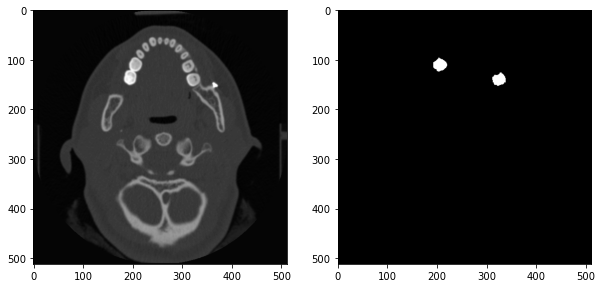

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
ax1.imshow(img, cmap='gray')
ax2.imshow(img_metal, cmap='gray')
#plt.savefig('metal-artifact.png')

In [5]:
#img = read_dcm('CT000209.dcm') #lendo imagem real
#img_metal = np.zeros(img.shape) #criando espaço para o metal
#img_metal[300:320, 300:320] = 1
#dataset = pydicom.dcmread('images_dcm/CT000209.dcm') #adquirindo dados do dicom
#pixel_size = float(dataset['PixelSpacing'][0]) #the real size of each pixel [cm]

## Passo 2 - adquirir dados

Realizar a criação de constantes para ser utilizado ao longo do código

In [6]:
data = pd.read_csv('xray_characteristic_data.csv')
energy_composition = np.linspace(0,119, 120).astype(int)
E0 = 40-1
mu_air = 0
mu_water = data.iloc[E0]['Water']
metal_name = 'Titanium'
metal_density = 4.5
T1 = 100
T2 = 1500
polynomial_order_for_correction = 3
noise_scale = 12

angle_num = 1000

## Passo 3 - pré-processamento

In [7]:
# 3º Passo - pré-processamento
img[img <= -500] = -1000
img = hu2mu(img, mu_water, mu_air)

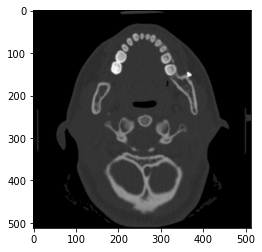

In [8]:
plt.imshow(img, cmap='gray')

## Passo 4 - Water correction

In [9]:
# 4º Passo - calibração do fantoma

#create_phantom
xsize = img.shape[0]
ysize = img.shape[1]
x_array = np.linspace(-(xsize-1)/2,(xsize-1)/2, xsize)
y_array = np.linspace(-(ysize-1)/2,(ysize-1)/2, ysize)
X, Y = np.meshgrid(x_array, y_array)
X_2 = np.power(X, 2)
Y_2 = np.power(Y, 2)
phantom = (X_2 + Y_2)< np.power(200,2)
phantom = phantom * mu_water

In [10]:
#water_correction
#phantom_proj_mono
d_water = Radon(phantom, angle_num)
d_water = d_water * pixel_size
y = np.exp(-d_water)
p_mono = -np.log(y)

In [11]:
#phantom_proj_poly
#Mesma coisa, não precisa recalcular
#d_water = Radon(img, angle_num)
#d_water = d_water * pixel_size
total_intensity = 0
v = np.zeros((len(energy_composition), d_water.shape[0], d_water.shape[1]))
m0_water = data.iloc[E0]['Water']
for i in energy_composition:
    m_water = data.iloc[i]['Water']
    intensity = data.iloc[i]['Intensity']
    d_water_tmp = d_water*(m_water/m0_water)
    y = intensity * (np.exp(-d_water_tmp))
    v[i, :, :] = y
    total_intensity = total_intensity + intensity
poly_p = np.sum(v, 0)
p_poly = -np.log(poly_p/total_intensity)

In [12]:
# Choose one of those
#corr_coeff = np.polyfit(p_poly.flatten('F'), p_mono.flatten('F'), polynomial_order_for_correction)
temp = np.polynomial.polynomial.polyfit(p_poly.flatten('F'), p_mono.flatten('F'), polynomial_order_for_correction)

In [13]:
corr_coeff = temp[::-1]

In [14]:
corr_coeff

array([-6.57023182e-03,  7.68411049e-02,  9.82996594e-01, -1.09996034e-04])

## Passo 5 - Simulação

In [15]:
m0_water = data.iloc[E0]['Water']
m0_bone = data.iloc[E0]['Bone']
m0_metal = data.iloc[E0][metal_name]
mu_water0 = m0_water * 1.0
mu_metal0 = m0_metal * metal_density

T1 = hu2mu(T1, mu_water0, mu_air)
T2 = hu2mu(T2, mu_water0, mu_air)

In [16]:
# Threshold based weighting
[x_water, x_bone] = threshold_based_weighting(img, T1, T2)

In [17]:
x_bone[img_metal>0] = 0
x_water[img_metal>0] = 0
img_metal = img_metal * mu_metal0

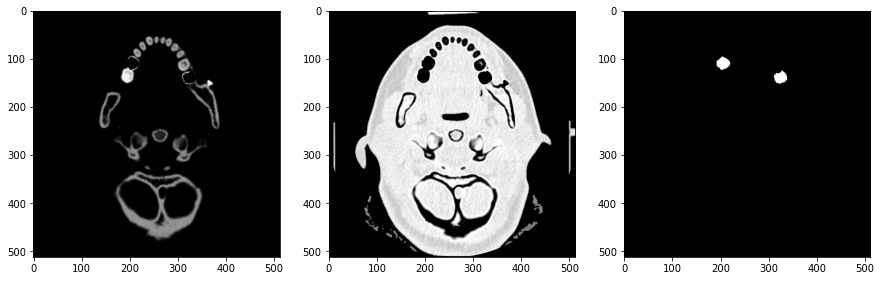

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,15))
ax1.imshow(x_bone, cmap='gray')
ax2.imshow(x_water, cmap='gray')
ax3.imshow(img_metal, cmap='gray')
#plt.savefig('bone_water_metal.png')

In [19]:
# Parallel Beam - cant implement fan 'arc' beam
d_water = Radon(x_water, angle_num)
d_bone = Radon(x_bone, angle_num)
d_metal = Radon(img_metal, angle_num)

In [20]:
d_metal = d_metal * pixel_size
d_bone = d_bone * pixel_size
d_water = d_water * pixel_size

total_intensity = 0
v = np.zeros((len(energy_composition), d_water.shape[0], d_water.shape[1]))

In [21]:
#Monochromatic
intensity = data.iloc[E0]['Intensity']
DRR = d_water + d_bone + d_metal
y = intensity * (np.exp(-DRR))
total_intensity = intensity

poly_y_mono = np.copy(y)

#noisy_y_mono = np.random.poisson(lam=poly_y_mono, size=None)
p_mono = -np.log(poly_y_mono/total_intensity)
p_final_mono = p_mono
p_final_mono = np.polyval(corr_coeff, p_mono)

In [22]:
#Polichromatic
for i in energy_composition:
    m_water = data.iloc[i]['Water']
    m_bone = data.iloc[i]['Bone']
    m_metal = data.iloc[i][metal_name]
    intensity = data.iloc[i]['Intensity']
    d_water_tmp = d_water*(m_water/m0_water)
    d_bone_tmp = d_bone*(m_bone/m0_bone)
    d_metal_tmp = d_metal*(m_metal/m0_metal)
    DRR = d_water_tmp + d_bone_tmp + d_metal_tmp
    
    y = intensity * (np.exp(-DRR))
    v[int(i), :, :] = y
    total_intensity = total_intensity + intensity
    
poly_y = sum(v, 0)
#noisy_y = np.random.poisson(lam=poly_y, size=None)
p = -np.log(poly_y/total_intensity)
p_final_poly = p
p_final_poly = np.polyval(corr_coeff, p)

## Passo 6 - Reconstrução da imagem

In [23]:
sim_mono = Iradon(p_final_mono, angle_num)
# É nesse passo q surge a diferença imensa
# Diferença entre máximo e mínimo após iradon é muito baixa em relação ao matlab
sim_mono[sim_mono < 0] = 0
sim_mono = sim_mono / pixel_size
output_mono = mu2hu(sim_mono, mu_water, mu_air)

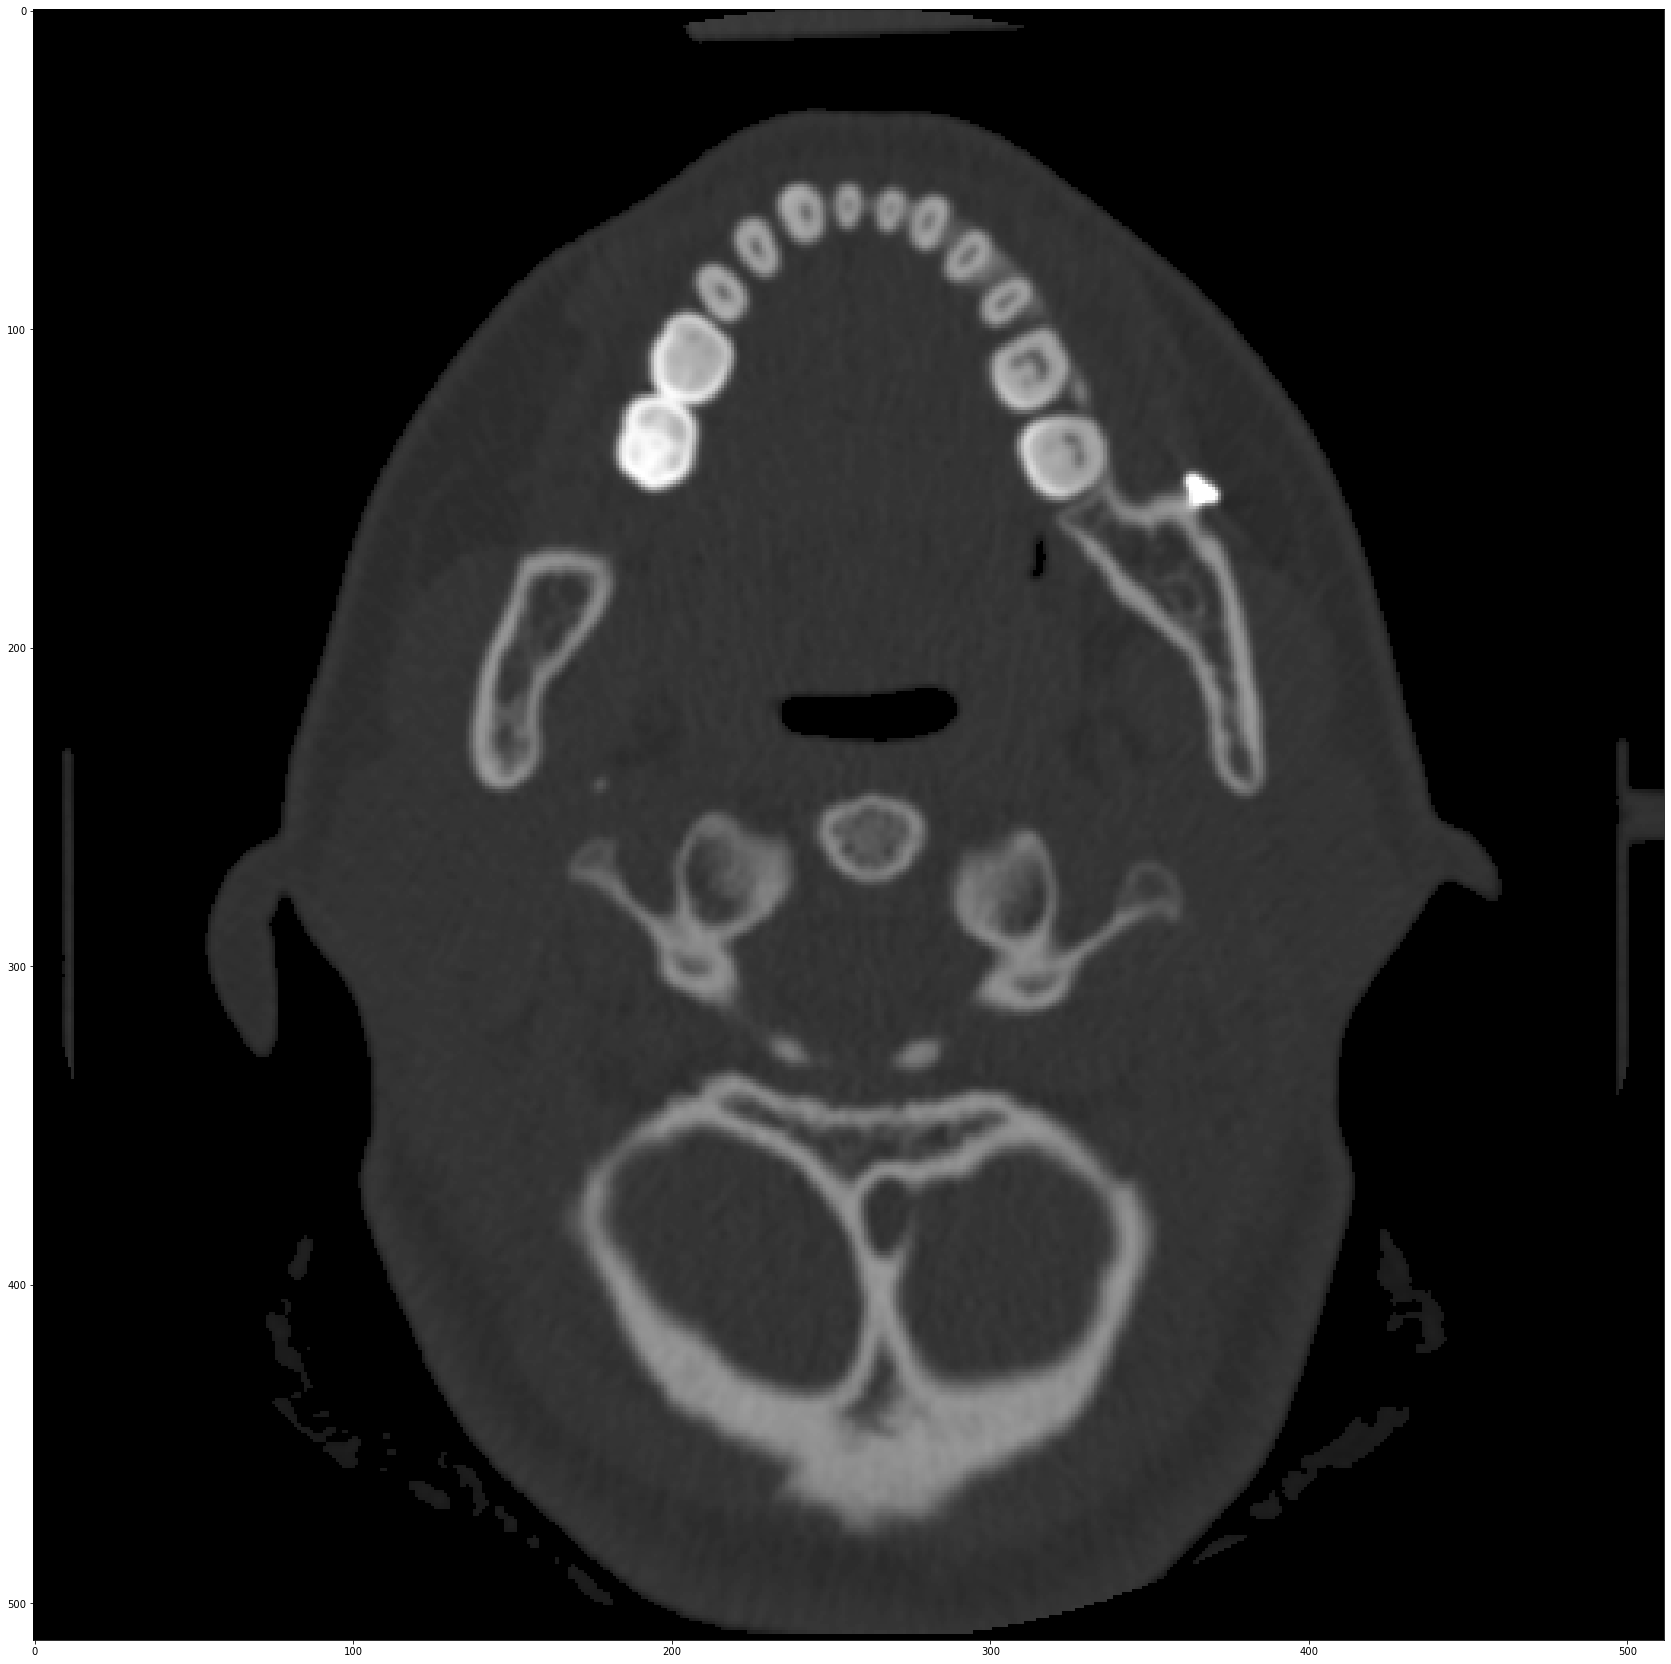

In [24]:
fig, ax1 = plt.subplots(1, 1, figsize=(30,30))
ax1.imshow(mu2hu(img, mu_water, mu_air), cmap='gray')
plt.savefig('original_mono.png', dpi=300)

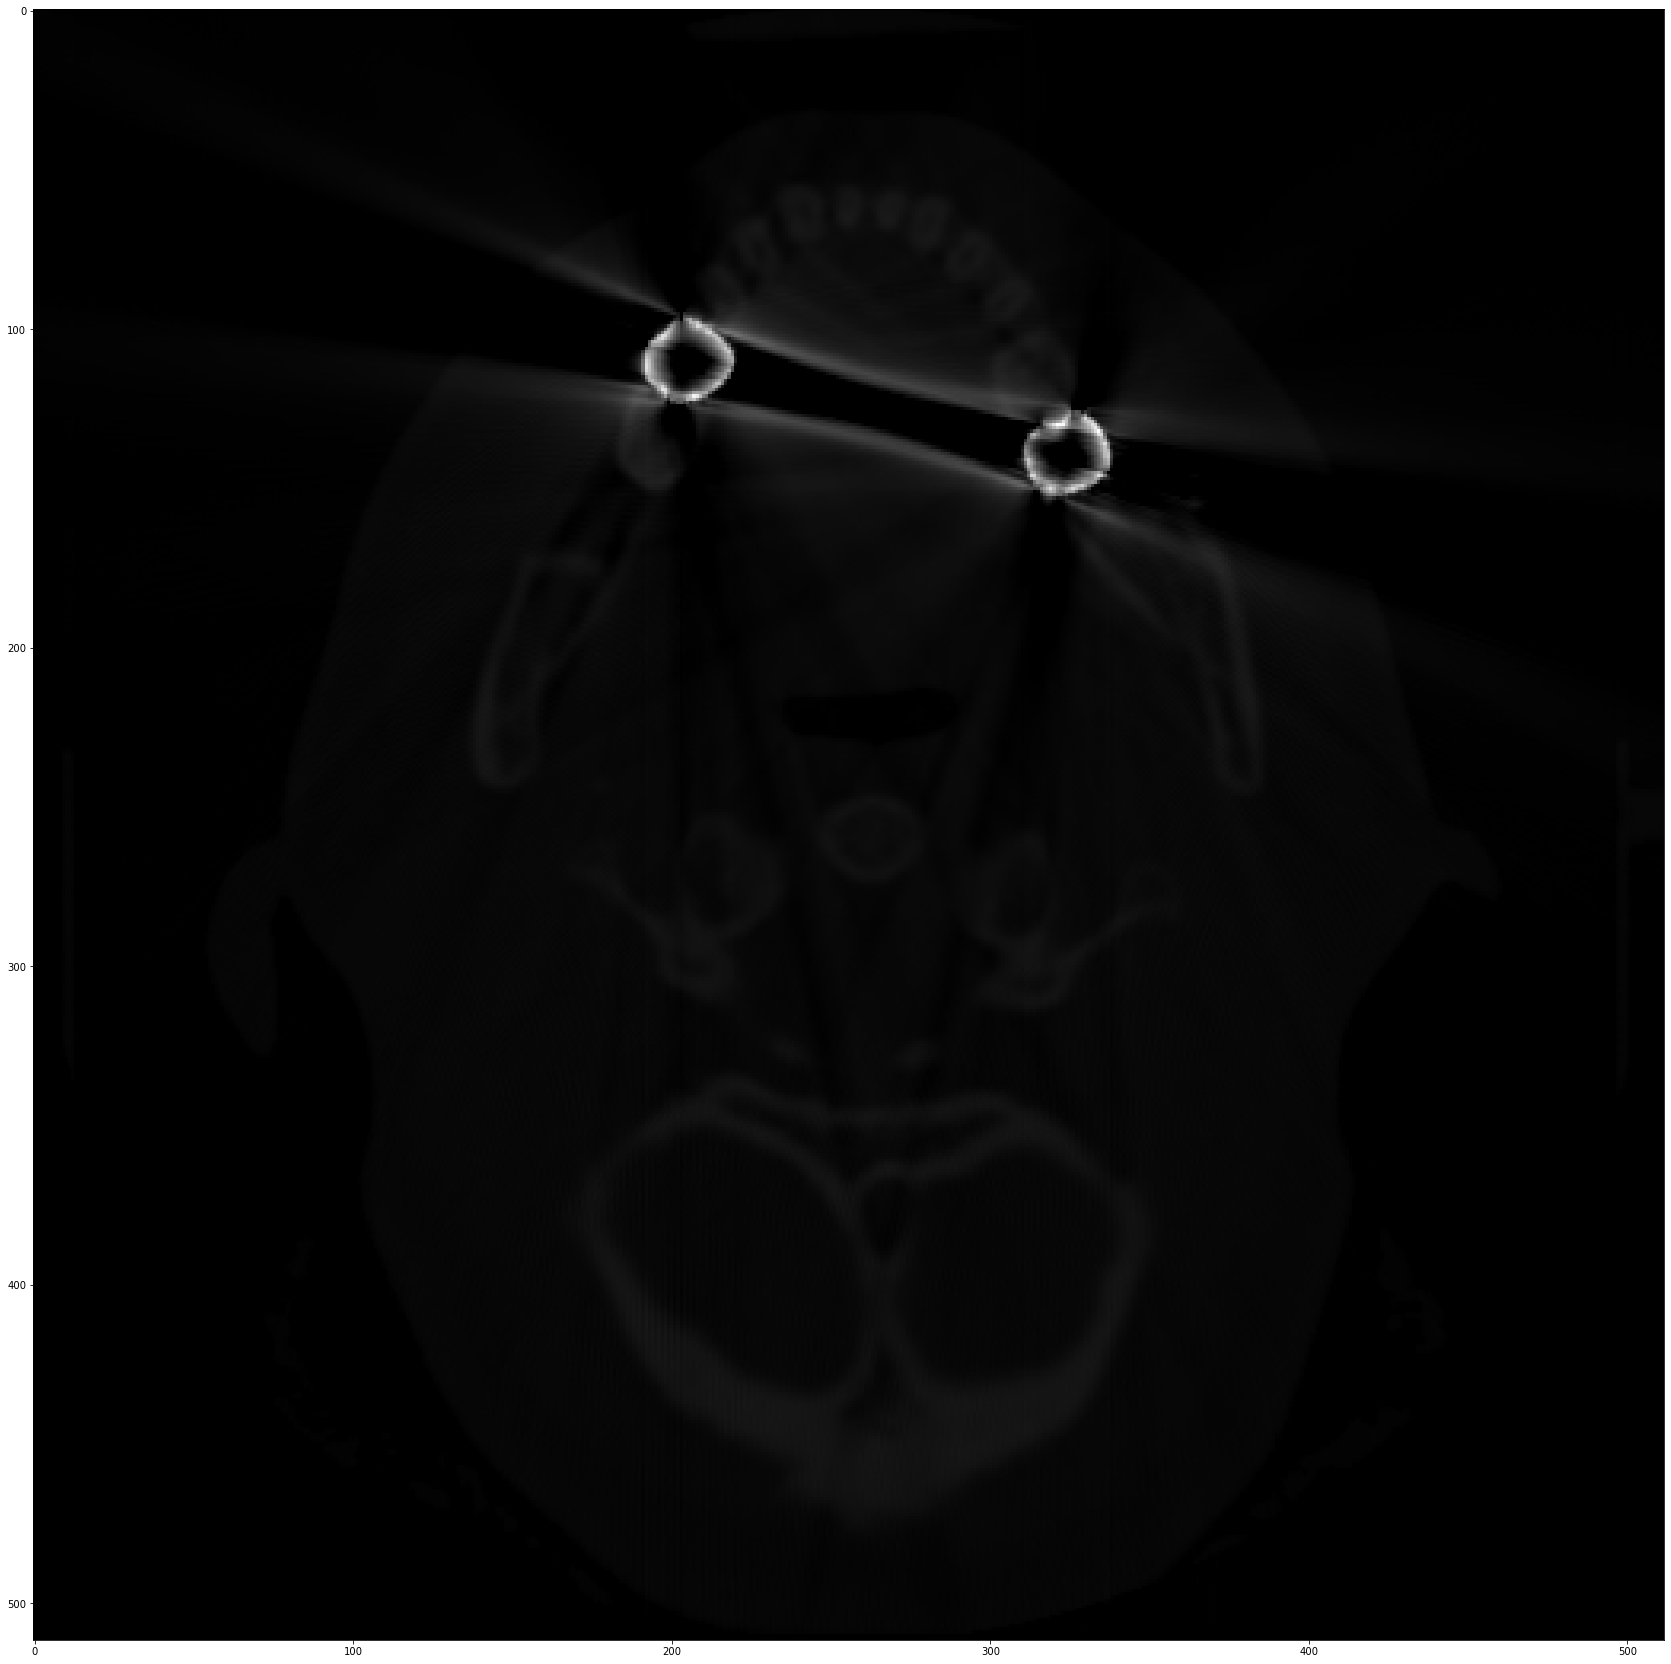

In [25]:
fig, ax1 = plt.subplots(1, 1, figsize=(30,30))
ax1.imshow(output_mono, cmap='gray')
plt.savefig('MAS_mono.png', dpi=300)

In [26]:
sim_poly = Iradon(p_final_poly, angle_num)
# É nesse passo q surge a diferença imensa
# Diferença entre máximo e mínimo após iradon é muito baixa em relação ao matlab
sim_poly[sim_poly < 0] = 0
sim_poly = sim_poly / pixel_size
output_poly = mu2hu(sim_poly, mu_water, mu_air)

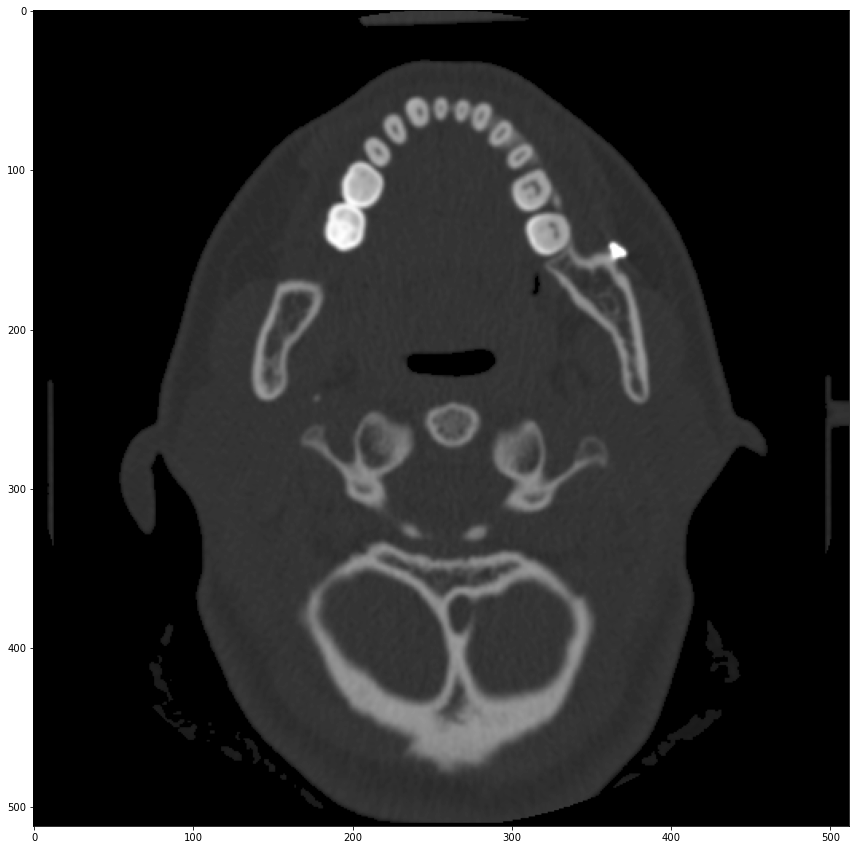

In [27]:
fig, ax1 = plt.subplots(1, 1, figsize=(15,15))
ax1.imshow(mu2hu(img, mu_water, mu_air), cmap='gray')
plt.savefig('original_poly.png', dpi=300)

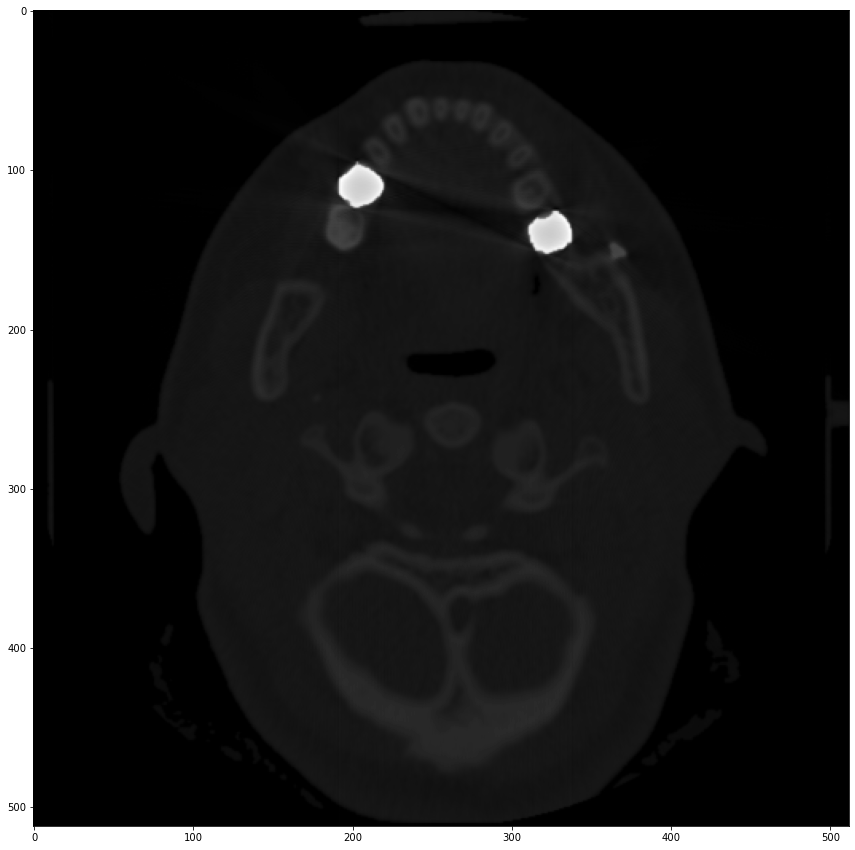

In [28]:
fig, ax1 = plt.subplots(1, 1, figsize=(15,15))
ax1.imshow(output_poly, cmap='gray')
plt.savefig('MAS_poly.png', dpi=300)

****

In [29]:
def get_artifact_from_data(image, threshold):
    x, y = image.shape
    image_metal = np.zeros((x, y))
    for i in range(x):
        for j in range(y):
            if(image[i, j] >= threshold):
                image_metal[i, j] = threshold
    return image_metal

def simple_MAR(img, threshold = 3000):
    sinogram = Radon(img)
    image_metal = get_artifact_from_data(img, threshold)
    sinogram_metal = Radon(image_metal)
    sinogram_corrected = sinogram - sinogram_metal
    fbp = Iradon(sinogram_corrected)
    return fbp

output_corrected = simple_MAR(output)

NameError: name 'output' is not defined

****
# Corrigir

In [ ]:
#dataset = pydicom.dcmread('images_dcm/CT000209.dcm') #adquirindo dados do dicom

In [ ]:
# 1º passo - iniciar
#img = read_dcm('CT000209.dcm') #lendo imagem real
#img_metal = np.zeros(img.shape) #criando espaço para o metal
#img_metal[300:320, 300:320] = 1
#pixel_size = float(dataset['PixelSpacing'][0]) #the real size of each pixel [cm]

In [ ]:
#plt.imshow(img_metal, cmap="gray")
#plt.savefig('CT_1.25_MMC_CT000120_original.png')